### Importowanie wymaganych bibliotek

In [ ]:
!apt-get update > /dev/null
!apt-get install -y openmpi-bin libopenmpi-dev > /dev/null
!pip install mpi4py numba numpy matplotlib > /dev/null
print("Srodowisko gotowe.")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ Środowisko gotowe.


### Ustawienie srodowiska dla Numby + logika dla CPU oraz GPU (CUDA)

In [ ]:
%%writefile hpc_traffic.py
import time
import numpy as np
import os
import sys

os.environ['NUMBAPRO_CUDALIB'] = '/usr/local/cuda/lib64'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice'

try:
    from mpi4py import MPI
    USE_MPI = True
except ImportError:
    USE_MPI = False

try:
    from numba import njit, cuda, prange
    HAS_CUDA = cuda.is_available()
except ImportError:
    sys.exit(0)

# konfiguracja testowa
NUM_STEPS = 600
NUM_INTERSECTIONS = 40000
MAX_QUEUE = 100
GREEN_DURATION = 20
AMBER_DURATION = 2

# logika dla CPU
@njit(fastmath=True)
def cpu_logic(idx, queues_count, phases, timers, stats_departures, step_idx):
    timers[idx] += 1
    if timers[idx] >= 22:
        phases[idx] = 1 - phases[idx]
        timers[idx] = 0
    
    current_phase = phases[idx]
    is_green_ns = (current_phase == 0 and timers[idx] < 20)
    is_green_ew = (current_phase == 1 and timers[idx] < 20)

    pseudo_rand = (idx * 12345 + step_idx * 6789) % 100
    spawn_dir = step_idx % 4 
    if pseudo_rand < 30:
        if queues_count[idx, spawn_dir] < MAX_QUEUE:
            queues_count[idx, spawn_dir] += 1

    for d in range(4):
        can_go = False
        if (d == 0 or d == 2) and is_green_ns: can_go = True
        if (d == 1 or d == 3) and is_green_ew: can_go = True
        
        if can_go and queues_count[idx, d] > 0:
            queues_count[idx, d] -= 1
            stats_departures[idx] += 1

@njit(parallel=True)
def run_openmp(num_nodes, steps, q_count, ph, tmr, s_dep):
    for step in range(steps):
        for i in prange(num_nodes):
            cpu_logic(i, q_count, ph, tmr, s_dep, step)

if HAS_CUDA:
    @cuda.jit(fastmath=True)
    def run_cuda_kernel(num_nodes, steps, q_count, ph, tmr, s_dep):
        i = cuda.grid(1)
        if i < num_nodes:
            for step in range(steps):
                tmr[i] += 1
                if tmr[i] >= 22:
                    ph[i] = 1 - ph[i]
                    tmr[i] = 0
                
                is_green_ns = False
                is_green_ew = False
                if ph[i] == 0 and tmr[i] < 20: is_green_ns = True
                if ph[i] == 1 and tmr[i] < 20: is_green_ew = True

                pseudo_rand = (i * 12345 + step * 6789) % 100
                spawn_dir = step % 4 
                if pseudo_rand < 30:
                    if q_count[i, spawn_dir] < 100: q_count[i, spawn_dir] += 1

                for d in range(4):
                    can_go = False
                    if d == 0 or d == 2:
                        if is_green_ns: can_go = True
                    elif d == 1 or d == 3:
                        if is_green_ew: can_go = True
                    
                    if can_go and q_count[i, d] > 0:
                        q_count[i, d] -= 1
                        s_dep[i] += 1


def main():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()
    items_per_proc = NUM_INTERSECTIONS // size
    
    local_q_count = np.zeros((items_per_proc, 4), dtype=np.int32)
    local_phases = np.zeros(items_per_proc, dtype=np.int32)
    local_timers = np.zeros(items_per_proc, dtype=np.int32)
    local_stats_dep = np.zeros(items_per_proc, dtype=np.int32)

    # CPU run
    if USE_MPI: comm.Barrier()
    t_start = time.time()
    run_openmp(items_per_proc, NUM_STEPS, local_q_count, local_phases, local_timers, local_stats_dep)
    if USE_MPI: comm.Barrier()
    t_end = time.time()
    
    if rank == 0:
        print(f"DATA_CPU:{t_end - t_start:.4f}")

    # GPU run (cuda)
    if HAS_CUDA and rank == 0:
        d_q_count = cuda.to_device(np.zeros((NUM_INTERSECTIONS, 4), dtype=np.int32))
        d_phases = cuda.to_device(np.zeros(NUM_INTERSECTIONS, dtype=np.int32))
        d_timers = cuda.to_device(np.zeros(NUM_INTERSECTIONS, dtype=np.int32))
        d_stats_dep = cuda.to_device(np.zeros(NUM_INTERSECTIONS, dtype=np.int32))
        
        threads = 128
        blocks = (NUM_INTERSECTIONS + (threads - 1)) // threads
        
        t_g_start = time.time()
        run_cuda_kernel[blocks, threads](NUM_INTERSECTIONS, NUM_STEPS, d_q_count, d_phases, d_timers, d_stats_dep)
        cuda.synchronize()
        t_g_end = time.time()
        
        print(f"DATA_GPU:{t_g_end - t_g_start:.4f}")

if __name__ == "__main__":
    main()

Overwriting hpc_traffic.py


### Testy

In [ ]:
import subprocess
import re

results = {
    'cores': [1, 2, 4],
    'cpu_times': [],
    'gpu_time': 0.0
}

def run_experiment(n_cores):
    print(f"Uruchamianie symulacji na {n_cores} procesach MPI...")
    cmd = f"mpirun --allow-run-as-root --oversubscribe -n {n_cores} python hpc_traffic.py"
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    
    cpu_match = re.search(r"DATA_CPU:([\d\.]+)", result.stdout)
    gpu_match = re.search(r"DATA_GPU:([\d\.]+)", result.stdout)
    
    cpu_t = float(cpu_match.group(1)) if cpu_match else 0.0
    gpu_t = float(gpu_match.group(1)) if gpu_match else 0.0
    
    print(f"   -> Czas CPU: {cpu_t:.4f} s")
    if gpu_t > 0:
        print(f"   -> Czas GPU: {gpu_t:.4f} s")
        results['gpu_time'] = gpu_t
        
    return cpu_t

print("Funkcje testowe gotowe")

✅ Funkcje testowe gotowe.


### Testy na roznych liczbach procesow

In [ ]:
# 1 proces
t1 = run_experiment(1)
results['cpu_times'].append(t1)

# 2 procesy
t2 = run_experiment(2)
results['cpu_times'].append(t2)

# 4 procesy
t4 = run_experiment(4)
results['cpu_times'].append(t4)

print("\n🎉 Wszystkie testy zakończone!")
print("Wyniki:", results)

🚀 Uruchamianie symulacji na 1 procesach MPI...
   -> Czas CPU: 1.3957 s
   -> Czas GPU: 0.3439 s
🚀 Uruchamianie symulacji na 2 procesach MPI...
   -> Czas CPU: 1.3312 s
   -> Czas GPU: 0.2873 s
🚀 Uruchamianie symulacji na 4 procesach MPI...
   -> Czas CPU: 2.2541 s
   -> Czas GPU: 0.4449 s

🎉 Wszystkie testy zakończone!
Wyniki: {'cores': [1, 2, 4], 'cpu_times': [1.3957, 1.3312, 2.2541], 'gpu_time': 0.4449}


### Wykresy czasu wykonania oraz efektywnosci

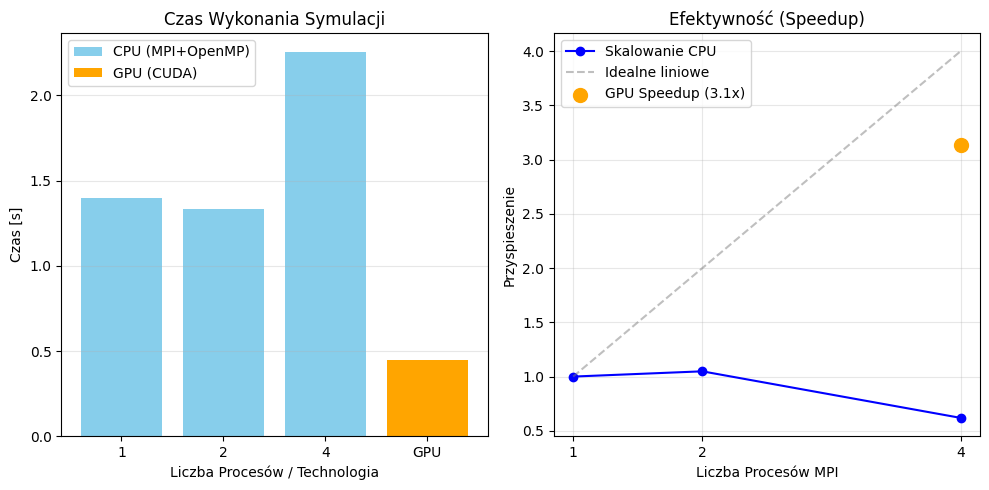

In [ ]:
import matplotlib.pyplot as plt

cores = results['cores']
cpu_times = results['cpu_times']
gpu_time = results['gpu_time']

speedup_cpu = [cpu_times[0] / t for t in cpu_times]
speedup_gpu = cpu_times[0] / gpu_time if gpu_time > 0 else 0

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
bars = plt.bar([str(c) for c in cores], cpu_times, color='skyblue', label='CPU (MPI+OpenMP)')
plt.bar('GPU', gpu_time, color='orange', label='GPU (CUDA)')

plt.title('Czas Wykonania Symulacji')
plt.ylabel('Czas [s]')
plt.xlabel('Liczba Procesów / Technologia')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# wykres przyspieszenia
plt.subplot(1, 2, 2)
plt.plot(cores, speedup_cpu, marker='o', linestyle='-', color='blue', label='Skalowanie CPU')
plt.plot(cores, cores, linestyle='--', color='gray', alpha=0.5, label='Idealne liniowe')
plt.scatter([4], [speedup_gpu], color='orange', s=100, zorder=5, label=f'GPU Speedup ({speedup_gpu:.1f}x)')

plt.title('Efektywność (Speedup)')
plt.ylabel('Przyspieszenie')
plt.xlabel('Liczba Procesów MPI')
plt.xticks(cores)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Wizualizacja stanu

In [ ]:
import matplotlib.pyplot as plt

def draw_grid(phase_ns_green):
    grid_size = 15
    x, y = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
    
    plt.figure(figsize=(6, 6))
    ax = plt.gca()
    ax.set_facecolor('#222')
    
    color = '#00FF00' if phase_ns_green else '#FF0000'
    label = 'Faza NS (Pion)' if phase_ns_green else 'Faza EW (Poziom)'
    
    plt.scatter(x, y, c=color, s=150, marker='s', label='Sygnalizacja')
    
    np.random.seed(42 if phase_ns_green else 99)
    cx = np.random.randint(0, grid_size, 60)
    cy = np.random.randint(0, grid_size, 60) + np.random.randn(60)*0.1
    
    car_color = 'white' if phase_ns_green else 'yellow'
    car_label = 'Jadą (NS)' if phase_ns_green else 'Jadą (EW)'
    
    plt.scatter(cx, cy, c=car_color, s=15, label=car_label)
    
    plt.title(f"Symulacja Ruchu: {label}")
    plt.legend(loc='upper right')
    plt.show()

print("Wizualizacja Krok 10 (Zielone dla NS):")
draw_grid(True)
print("Wizualizacja Krok 30 (Zmiana -> Zielone dla EW):")
draw_grid(False)

Wizualizacja Krok 10 (Zielone dla NS):


NameError: name 'np' is not defined